## Creating_GTD.ipynb


Creat the ground truth dataset for European blocking events

This is done by creating a PDF containing the spaghetti plots and five days of geopotential height data for every continuous five day period within JJA.

From manual inspection, I can then determine myself if a blocking event persists across that five day interval

This creates a dataset that can be translated into a blocking specification for the days in Europe when a summer blocking event has occurred.




In [1]:
import netCDF4 as nc
import xarray
import xarray as xr
import numpy as np
import scipy
from scipy.integrate import simps
import glob
import matplotlib.pyplot as plt
#libraries for colormap class
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from itertools import groupby
from operator import itemgetter
import math
import pandas as pd
import itertools
from operator import itemgetter
from itertools import groupby
from IPython.display import clear_output
import datetime
import matplotlib.patches as mpatches
from cartopy.util import add_cyclic_point
import plot_funcs as pf


In [2]:
from matplotlib.backends.backend_pdf import PdfPages
from csv import writer

In [3]:
class MplColorHelper:
        def __init__(self, cmap_name, start_val, stop_val):
            self.cmap_name = cmap_name
            self.cmap = plt.get_cmap(cmap_name)
            self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
            self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

        def get_rgb(self, val):
            return self.scalarMap.to_rgba(val)


COL = MplColorHelper('seismic', -330, 330)
bounds = np.arange(-330,360,30)
cols=COL.get_rgb(bounds)

green_cols = np.array(list(zip(cols[:,1],cols[:,0],cols[:,2],cols[:,3])))[12:]
purp_cols = np.array(list(zip(cols[:,0],cols[:,1],cols[:,0],cols[:,3])))[12:]

cols_cont_rearr = np.concatenate((np.flip(purp_cols, 0), green_cols), axis = 0)
newcmp = ListedColormap(cols_cont_rearr)

In [4]:
dir_str = "C:/Users/carlt/Documents/PhD/Data/cmip6\\UK-ESM1-0-LL_piControl\\"
##mrso_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-19601230.nc
mrso = xr.open_dataset(f"{dir_str}mrso_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-19601230.nc")['mrso'].squeeze()

psl = xr.open_dataset(f"{dir_str}psl_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_NHML_JJAextd.nc")['psl']/100
zg = xr.open_dataset(f"{dir_str}500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_NHML_JJAextd.nc")['zg'].squeeze()


In [5]:
def da_lon_adj(da):
    """
    Reset the longitude coordinates if they are defined from 0-360 E to -180 - 180 E.
    """
    #identify label for the longitude coordinate
    if "longitude" in str(da.coords):
        lon_str = "longitude"
    else:
        lon_str = "lon"
    if int(da[lon_str].max()>180):
        #calculate longitude resolution
        lon_diff = abs(int(da[lon_str][1]-da[lon_str][0]))
        #redefine 0-360 degrees E to -180 - +180 deg E, setting meridi
        lon_adj = da[lon_str]*(da[lon_str]<(180+lon_diff/2))+((da[lon_str]-360)*(da[lon_str]>180))
        da_lon_adj = da.copy()
        da_lon_adj[lon_str] = lon_adj
        da_roll = da_lon_adj.roll(lon = 89, roll_coords=True)
        #check that the output longitude coordinates are in ascending order
        if False not in np.array(da[lon_str].values==da[lon_str].sortby(lon_str, ascending=True).values):
            return da_roll
        else:
            print("ERROR - longitude coordinates are not in ascending order")
            return 1
    else:
        return da

In [6]:
eur_lats = np.arange(29.375, 76.875, 1.25)
eur_lats_extd = np.arange(29.375-1.25*4, 76.875+1.25*4, 1.25)
eur_lons = np.arange(169.6875-180, 220.3125+1.875-180, 1.875)
styr_samp, endyr_samp = 2010, 2012

zg_lon_adj = da_lon_adj(zg)
zg_lon_adj_sel = zg_lon_adj.sel(lon = eur_lons, lat = eur_lats)

psl_lon_adj = da_lon_adj(psl)
psl_lon_adj_sel = psl_lon_adj.sel(lon = eur_lons, lat = eur_lats)


In [7]:
zg_lon_adj_sel_anom = zg_lon_adj_sel.groupby("time.dayofyear") - zg_lon_adj_sel.groupby("time.dayofyear").mean()

In [8]:
psl_lon_adj_sel_anom = psl_lon_adj_sel.groupby("time.dayofyear") - psl_lon_adj_sel.groupby("time.dayofyear").mean()

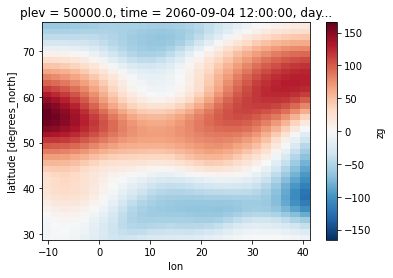

In [23]:
zg_anom_sel[-1].plot()

In [9]:
zg_anom_sel = zg_lon_adj_sel_anom
psl_anom_sel = psl_lon_adj_sel_anom
zg_sel = zg

In [10]:
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)
        

def fldmean_xr(xr_da):
    """
    Calculate the area averaged mean from an xarray DataArray with coordinates time, latitude, longitude
    will need to be adapted if data is not 3d e.g. if there are other levels
    """
    #print(xr_da)
    #print(xr_da.shape)
    if "latitude" in str(xr_da):
        lat_str, lon_str = "latitude", "longitude"
    else:
        lat_str, lon_str = "lat", "lon"
    import numpy as np
    import xarray as xr
    #multiply the ataarray by the relevant weights using cos(latitude)
    xr_da_latcorr = (xr_da*np.cos(np.radians(xr_da[lat_str])))    
    #calculate the weighted mean by summing across all the weighted values and dividing by the total sum of all weights appliced
    if xr.ufuncs.isnan(xr_da[0]).sum() > 0:
        print("Masked")
        #calculating the weighted mean for a masked array
        isnan = xr.ufuncs.isnan(xr_da[0])
        xr_da_latcorr = (xr_da*np.cos(np.radians(xr_da[lat_str])))
        weights_sum = ((isnan==0)*np.cos(np.radians(xr_da[lat_str]))).sum()
        xr_da_fldmean_latcorr = xr_da_latcorr.sum(axis=1, skipna=True).sum(axis=1, skipna=True)/weights_sum
    
    
    if len(xr_da.shape) == 3:
        xr_da_fldmean_latcorr = xr_da_latcorr.sum(axis=1).sum(axis=1)/(np.cos(np.radians(xr_da_latcorr[lat_str])).sum()*xr_da_latcorr[lon_str].shape[0])
    if len(xr_da.shape) == 2:
        xr_da_fldmean_latcorr = xr_da_latcorr.sum(axis=1).sum(axis=0)/(np.cos(np.radians(xr_da_latcorr[lat_str])).sum()*xr_da_latcorr[lon_str].shape[0])        
    return xr_da_fldmean_latcorr
        

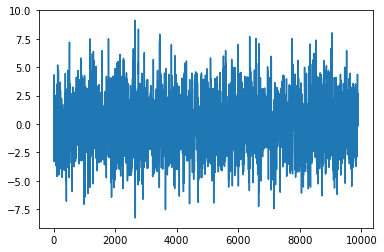

In [19]:
lat_idx, lon_idx = 0, -1

plt.plot(range(9898), psl_anom_sel[:,lat_idx,lon_idx])

In [11]:
day_idx = 0
num_days = 5
alpha_sp = 0.8
fs_sp_lab = 9
fs_contour_plots = 9
fs_cb_ticks = 7
fs_cb_label = 7

def date_str(date):
    day, month, year_str = int(date.dt.day), int(date.dt.month), int(date.dt.year)
    day_str, month_str = f"{day:02d}", f"{month:02d}"
    date_str = f"{day_str}-{month_str}-{year_str}"
    return date_str

def consecutive_weather_maps(day_idx, num_days):
    """
    Plots a set of consecutive weather maps, including spaghetti plots of the gph field and five plots of the anomaly field
    """
    if True:#zg_anom_sel['time.year'][day_idx] == zg_anom_sel['time.year'][day_idx+num_days-1]:
        st_date = zg_anom_sel['time'][day_idx]
        end_date = zg_anom_sel['time'][day_idx+num_days-1]

        st_date_str = date_str(st_date)
        end_date_str = date_str(end_date)

        # Initialize the grid
        grid = plt.GridSpec(3, num_days, wspace=0.1, hspace=0)
        fig = plt.figure()
        axs = []
        # make subplots
        levels_psl = np.arange(-22, 24, 2)#np.arange(-33, 36, 3)#np.arange(-27.5, 30, 2.5)     
        levels_zg = np.arange(-330,360,30)

        for i in range(day_idx, day_idx+num_days):
            ax = plt.subplot(grid[1, i-day_idx], projection = ccrs.PlateCarree())
            axs.append(ax)
            cs_zg = ax.contourf(zg_anom_sel['lon'], zg_anom_sel['lat'], zg_anom_sel[i], levels_zg, cmap=plt.get_cmap("seismic"), extend="both")
            ax.set_title(f"{date_str(zg_anom_sel['time'][i])}", fontsize=fs_contour_plots, pad=5)
            ax.coastlines()        

        for i in range(day_idx, day_idx+num_days):
            ax = plt.subplot(grid[2, i-day_idx], projection = ccrs.PlateCarree())
            axs.append(ax)
            #cs_pv = ax.contourf(zg_anom_sel['lon']-180, zg_anom_sel['lat'], zg_anom_sel_LTDM[i], levels_zg, cmap=plt.get_cmap("seismic"), extend="both")
            cs_pv = ax.contourf(psl_anom_sel['lon'], psl_anom_sel['lat'], psl_anom_sel[i], levels_psl, cmap=newcmp, extend="both")
            ax.coastlines()        
        cb_length = 0.35
        cb_thickness = 0.05
        cbaxes_zg = fig.add_axes([0.14, 0.05, cb_length, cb_thickness])     #xpos, ypos, length, thickness    
        cbaxes_pv = fig.add_axes([0.54, 0.05, cb_length, cb_thickness]) 
        cb_zg = fig.colorbar(cs_zg, cax = cbaxes_zg, orientation = "horizontal")        
        cb_pv = fig.colorbar(cs_pv, cax = cbaxes_pv, orientation = 'horizontal') 
        cb_zg.set_label("Z500 anom (m)", fontsize=fs_cb_label)  
        cb_zg.ax.tick_params(labelsize=fs_cb_ticks)    
        cb_pv.set_label("mslp anom (hPa)", fontsize=fs_cb_label)  
        cb_pv.ax.tick_params(labelsize=fs_cb_ticks)

        #create separate axis for the spaghetti plot
        ax_sp=plt.subplot(grid[0, :], projection = ccrs.PlateCarree())

        ax_sp.add_feature(cfeature.COASTLINE, edgecolor='black')
        ax_sp.set_aspect(1.0)
        #print(f"day_idx = {day_idx}")
        zg_sel.load()
        #print(zg_sel[day_idx:(day_idx+5),:,:])
        mean_gph_30_70 = fldmean_xr(zg_sel[day_idx:(day_idx+5),:,:].sel(lat=eur_lats).mean(axis=0))
        lat_sp, lon_sp = zg_sel['lat'], zg_sel['lon']
        #lat_sp, lon_sp = zg_anom_sel['lat'], zg_anom_sel['lon']
        for i in range(day_idx, day_idx+num_days):
            sp_0000 = zg[i,:,:]
            sp_0000, lon_sp_cp = add_cyclic_point(zg_sel[i,:,:].values, coord=lon_sp.values)     
            im5 = ax_sp.contour(lon_sp_cp, lat_sp, sp_0000, levels = [mean_gph_30_70] , colors='red', alpha=alpha_sp)
            #im6 = ax_sp.contour(lon_sp_cp, lat_sp, sp_0000, levels = [mean_gph_30_70 - 100*3] , colors='blue', alpha=alpha_sp-0.2)
            #im7 = ax_sp.contour(lon_sp_cp, lat_sp, sp_0000, levels = [mean_gph_30_70 + 100*3] , colors='green', alpha=alpha_sp-0.2)                     
        x=0.0065
        ax_sp.text(x, 0.05, f"{int(np.round(mean_gph_30_70))} m",
           verticalalignment='bottom', horizontalalignment='left',
           transform=ax_sp.transAxes,
           color='k', fontsize=8,
                 bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 2})

        ax_sp.text(x, 0.78, f"(a)",
           verticalalignment='bottom', horizontalalignment='left',
           transform=ax_sp.transAxes,
           color='k', fontsize=8,
                 bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 2})    

        ax_sp.text(x, -0.715, f"(b)",
           verticalalignment='bottom', horizontalalignment='left',
           transform=ax_sp.transAxes,
           color='k', fontsize=8,
                 bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 2})   
        ax_sp.text(x, -2.35, f"(c)",
           verticalalignment='bottom', horizontalalignment='left',
           transform=ax_sp.transAxes,
           color='k', fontsize=8,
                 bbox={'facecolor': 'w', 'alpha': 0.5, 'pad': 2}) 
        dates_str = f"{st_date_str} to {end_date_str}"    
        ax_sp.set_title(dates_str, fontsize=fs_sp_lab)
        #plt.close();
        return dates_str, fig
    else:
        return 0, 0
    

2011


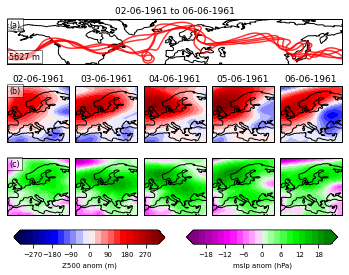

In [97]:
%matplotlib inline
#print one day
row_contents = ['Dates','Blocked']

import warnings
daysel = 103
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #specify day_idx vals for days 0 - (92-num_days) in each period, so that overlaps are not considered
    day_idx_vals = np.arange(zg_sel['time'].shape[0])
    for year in [2011]:
        print(year)
        csv_file = f"{dir_str}piControl_JJAextd_{year}-{year+num_yrs}.csv"
        with PdfPages(f"{dir_str}500z_GTD_samp.pdf") as pdf:
            for i, day_idx in enumerate(day_idx_vals):
                if daysel-1 < i < daysel+1:
                    #test if running this day would create an overlap of different timesteps
                    skip=False
                    if True:#(int(zg_anom_sel['time.year'][day_idx]) in np.arange(year, year+num_yrs+1, 1)):
                            dates_str, fig = consecutive_weather_maps(day_idx, num_days)
                            #append_list_as_row(csv_file, [dates_str, "0"]) 
                            if dates_str != 0:
                                pdf.savefig(fig, bbox_inches="tight")

In [13]:
row_contents = ['Dates','Blocked']

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #specify day_idx vals for days 0 - (92-num_days) in each period, so that overlaps are not considered
    day_idx_vals = np.arange(zg_sel['time'].shape[0])
    num_yrs = 2 # number of years in each sample
    for year in [2028]:
        print(year)
        csv_file = f"{dir_str}piControl_JJAextd_{year}-{year+num_yrs}.csv"
        with PdfPages(f"{dir_str}500z_GTD_classify_{num_days}_{year}-{year+num_yrs}_loncorr3.pdf") as pdf:
            for i, day_idx in enumerate(day_idx_vals):
                if i < 1:
                    #test if running this day would create an overlap of different timesteps
                    skip=False
                    if (int(zg_anom_sel['time.year'][day_idx]) in np.arange(year, year+num_yrs+1, 1)):
                            dates_str, fig = consecutive_weather_maps(day_idx, num_days)
                            #append_list_as_row(csv_file, [dates_str, "0"]) 
                            if dates_str != 0:
                                pdf.savefig(fig, bbox_inches="tight")

2028


In [13]:
row_contents = ['Dates','Blocked']

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #specify day_idx vals for days 0 - (92-num_days) in each period, so that overlaps are not considered
    day_idx_vals = np.arange(zg_sel['time'].shape[0])
    num_yrs = 10 # number of years in each sample
    for year in np.arange(2030,2060+num_yrs,num_yrs):
        print(year)
        csv_file = f"{dir_str}piControl_JJAextd_{year}-{year+num_yrs}.csv"
        with PdfPages(f"{dir_str}500z_GTD_classify_{num_days}_{year}-{year+num_yrs}_loncorr3.pdf") as pdf:
            for i, day_idx in enumerate(day_idx_vals):
                #if i < 2:
                    #test if running this day would create an overlap of different timesteps
                    skip=False
                    if (int(zg_anom_sel['time.year'][day_idx]) in np.arange(year, year+num_yrs+1, 1)):
                            dates_str, fig = consecutive_weather_maps(day_idx, num_days)
                            #append_list_as_row(csv_file, [dates_str, "0"]) 
                            if dates_str != 0:
                                pdf.savefig(fig, bbox_inches="tight")

2030
2040
2050


IndexError: index 9898 is out of bounds for axis 0 with size 9898

In [47]:
row_contents = ['Dates','Blocked']

#append_list_as_row(csv_file, row_contents)
#specify day_idx vals for days 0 - (92-num_days) in each period, so that overlaps are not considered
day_idx_vals = np.arange(zg_sel['time'].shape[0])
num_yrs = 50 # number of years in each sample
for year in np.arange(2010,2011+num_yrs,num_yrs):
    csv_file = f"{dir_str}piControl_JJAextd_{year}-{year+num_yrs}_totend.csv"
    #with PdfPages(f"{dir_str}500z_GTD_classify_{num_days}_{year}-{year+1}.pdf") as pdf:
    for i, day_idx in enumerate(day_idx_vals):
            #if i < 20: 
                #if i%100 == 0:
                #    print(float(zg_anom_sel['time'][day_idx].dt.year))
                #test if running this day would create an overlap of different timesteps
                skip=False
                #if (int(zg_anom_sel['time.year'][day_idx]) == int(zg_anom_sel['time.year'][day_idx+4])):
                if (int(zg_anom_sel['time.year'][day_idx]) in np.arange(year, year+num_yrs+1, 1)): 
                    #try:
                        #print(f"in year {int(zg_anom_sel['time'][day_idx].dt.year)}")
                        
                        st_date = zg_anom_sel['time'][day_idx]
                        end_date = zg_anom_sel['time'][day_idx+num_days-1]
                        if zg_anom_sel['time.year'][day_idx] == zg_anom_sel['time.year'][day_idx+num_days-1]:
                            st_date_str = date_str(st_date)
                            end_date_str = date_str(end_date)    
                            dates_str = f"{st_date_str} to {end_date_str}"
                            #print(dates_str)
                            #dates_str, fig = consecutive_weather_maps(day_idx, num_days)
                            append_list_as_row(csv_file, [dates_str, "0"])              
                        #pdf.savefig(fig, bbox_inches="tight")
                    #except ValueError:
                    #    print(f"Axis hasn't worked for {zg_anom_sel['time'][day_idx]}")

KeyboardInterrupt: 